# Validate

In [1]:
import os
import pickle
import json
from pathlib import Path
from typing import Sequence
from datetime import datetime, timedelta
from pprint import pprint

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, normaltest, shapiro
from numpy import typing as npt
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import statsmodels.api as sm

### Load Data

In [2]:
list_percentage_leaderboard = [
	2435, 2445, 2454, 2464, 2467, 2478, 2549, 2762, 2860, 3507, 3526, 3928, 4493,
	2489, 3353, 3366, 3509,
	2551, 2667, 2749, 3064, 3080, 3288, 3338, 3517, 3641, 3774, 3800, 3926, 3929,
	3960, 4031, 4043, 4104, 4366, 4407, 4453, 4477, 4488, 4657, 4699, 4986, 5056,
	5144, 5174, 5229, 5261, 5357, 5390, 5497, 6322, 6927, 7115, 7162, 7634, 7878,
	8076, 8078, 8219, 8396, 8540, 9120, 9949, 10200, 10684, 13333, 14242, 14420,
	18045, 19018, 19991, 20270, 21669, 22962, 23249, 23652, 37077, 38128, 38760,
]

In [3]:
# wd = os.getcwd()
wd = '/Volumes/RAWDATA/'
wd_data = Path(os.path.join(wd, '__jsondata_robust23__'))
print(wd_data)
lst_data_json = list(wd_data.glob("*.json"))
len(lst_data_json)

/Volumes/RAWDATA/__jsondata_robust23__


75

### Display Data

In [4]:
def plot_ts_events(
		time_grids: Sequence[datetime],
		ts: dict[str, Sequence | npt.NDArray],
		events: dict[str, Sequence | npt.NDArray],
		ts_colors,
		ts_linestyles,
		*,
		ylim=None,
		figsize=(10, 5),
		height_ratios=[3, 1],
):
	fig, (ax_main, ax_events) = plt.subplots(
		nrows=2, ncols=1, figsize=figsize, height_ratios=height_ratios,
	)
	if ylim is not None:
		ax_main.set_ylim(ylim[0], ylim[1])
	# plot time series
	idx_line = 0
	for ts_key, ts_val in ts.items():
		ax_main.plot(
			time_grids, ts_val, label=ts_key,
			color=ts_colors[idx_line],
			linestyle=ts_linestyles[idx_line],
		)
		idx_line += 1
	ax_main.legend(frameon=False)
	ax_main.xaxis.set_major_locator(MaxNLocator(nbins=8))
	xrange = ax_main.get_xlim()
	# plot events
	event_height = 0.2
	ytick = 0
	yticks = []
	yticklabels = []
	for event_key, event_val in events.items():
		yticks.append(ytick)
		yticklabels.append(event_key)
		ax_events.hlines(y=ytick, xmin=xrange[0], xmax=xrange[1], color='black')
		ax_events.vlines(x=event_val, ymin=ytick - event_height, ymax=ytick + event_height, color='black')
		ytick -= 2.5 * event_height
	ax_events.set_xlim(xrange)
	ax_events.get_xaxis().set_visible(False)
	ax_events.set_yticks(yticks)
	ax_events.set_yticklabels(yticklabels)
	return fig, ax_main, ax_events

def plot_contest_data(contest_data_json, contest_data_post):
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	N_Delta = contest_data_json['N_Delta']
	time_grids = [start_time + i * timedelta(hours=1) for i in range(N_Delta)]
	arr_hat_y = contest_data_json['hat_y']
	arr_real_y = contest_data_json['real_y']
	arr_tilde_y = contest_data_post['tilde_y'].mean(axis=0)
	hat_t_i = [start_time + timedelta(hours=t) for t in contest_data_json['hat_t_i']]
	hat_t_j = [start_time + timedelta(hours=t) for t in contest_data_json['hat_t_j']]
	#print(len(time_grids), len(arr_tilde_y))
	fig, ax_main, ax_events = plot_ts_events(
		time_grids=time_grids,
		ts={
			r'real output gap ($y_t$)': arr_real_y,
			r'observed output gap ($\hat{y}_t$)': arr_hat_y,
			r'perceived output gap ($\tilde{y}_t$)': arr_tilde_y[:-1],
		},
		events={
			r'player $i$': hat_t_i,
			r'player $j$': hat_t_j,
		},
		ts_colors = ['blue', 'black', 'black'],
		ts_linestyles=['solid', 'solid', 'dashed']
	)
	return fig, ax_main, ax_events

def plot_post_efforts(contest_data_json, contest_data_post):
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	N_Delta = contest_data_json['N_Delta']
	time_grids = [start_time + i * timedelta(hours=1) for i in range(N_Delta)]
	i_effort_dynamic = contest_data_post['m_i'].mean(axis=0)
	j_effort_dynamic = contest_data_post['m_j'].mean(axis=0)
	plt.figure(figsize=(10, 3))
	plt.plot(np.array(time_grids), i_effort_dynamic, label='player i')
	plt.plot(np.array(time_grids), j_effort_dynamic, label='player j')
	plt.legend()
	plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=8))
	plt.show()

In [5]:
def calculate_lambda_mle(arr_hat_y, arr_real_y, Delta2f) -> tuple[float, bool]:
	"""
	"""
	gap = [hat_y - y for hat_y, y in zip(arr_hat_y, arr_real_y)]
	gap_data = list(set(gap))
	# mle
	n = len(gap_data)
	mse = sum([x**2 for x in gap_data])
	if mse == 0.0:
		lambda_mle = float('nan')
	else:
		lambda_mle = n / mse / Delta2f
	# normal test
	normaltest_1 = normaltest(gap_data)
	normaltest_2 = shapiro(gap_data)
	return lambda_mle, normaltest_1.pvalue > 0.05 or normaltest_2.pvalue > 0.05

def estimate_effort_kde(contest_data_json, bw: float = 0.5):
	"""Using kernel density estimation to estimate submisison intensity

	Return: intensity per hour
	"""
	N_Delta = contest_data_json['N_Delta']
	time_grids_f = [i for i in range(N_Delta)]  # float
	hat_t_i_f = np.array(contest_data_json['hat_t_i'])
	hat_t_j_f = np.array(contest_data_json['hat_t_j'])

	kde_i = gaussian_kde(hat_t_i_f, bw_method=bw)
	kde_j = gaussian_kde(hat_t_j_f, bw_method=bw)
	density_i = kde_i(time_grids_f)
	density_j = kde_j(time_grids_f)
	intensity_i = density_i * len(hat_t_i_f)
	intensity_j = density_j * len(hat_t_j_f)

	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	time_grids = [start_time + timedelta(hours=i) for i in time_grids_f]
	hat_t_i = [start_time + timedelta(hours=t) for t in hat_t_i_f]
	hat_t_j = [start_time + timedelta(hours=t) for t in hat_t_j_f]
	return time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j

def calculate_sigma_mle(contest_data_json, contest_data_post) -> tuple[float, bool]:
	# json data
	N_Delta = contest_data_json['N_Delta']
	time_grids_f = [i for i in range(N_Delta)]  # float
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	time_grids = time_grids = [start_time + timedelta(hours=i) for i in time_grids_f]
	arr_real_y = contest_data_json['real_y']
	Delta2f = contest_data_json['Delta2f']
	hat_t_i_f = np.array(contest_data_json['hat_t_i'])
	hat_t_j_f = np.array(contest_data_json['hat_t_j'])
	hat_t_i = [start_time + timedelta(hours=t) for t in hat_t_i_f]
	hat_t_j = [start_time + timedelta(hours=t) for t in hat_t_j_f]

	# posteriors
	effort_gap = contest_data_post['effort_gap'].mean(axis=0)

	# departion
	N = n_i = n_j = 0
	arr_tk = []
	arr_y_tk = []
	arr_sum_effort_gap = []
	sum_effort_gap = 0
	for t, y, effort_gap_s in zip(time_grids, arr_real_y, effort_gap):
		sum_effort_gap += effort_gap_s
		if n_i < len(hat_t_i) and t - timedelta(hours=1) < hat_t_i[n_i] < t:
			if len(arr_tk) > 0 and hat_t_i[n_i] <= arr_tk[-1]:
				n_i += 1
				continue
			arr_tk.append(hat_t_i[n_i])
			arr_y_tk.append(y)
			arr_sum_effort_gap.append(sum_effort_gap * Delta2f)
			sum_effort_gap = 0
			n_i += 1
			N += 1
		if n_j < len(hat_t_j) and t - timedelta(hours=1) < hat_t_j[n_j] < t:
			if len(arr_tk) > 0 and hat_t_j[n_j] <= arr_tk[-1]:
				n_j += 1
				continue
			arr_tk.append(hat_t_j[n_j])
			arr_y_tk.append(y)
			arr_sum_effort_gap.append(sum_effort_gap * Delta2f)
			sum_effort_gap = 0
			n_j += 1
			N += 1
	arr_sum_effort_gap = arr_sum_effort_gap[1:]  # drop the first

	# MLE
	arr_delta_tk = [(arr_tk[ii + 1] - arr_tk[ii]).total_seconds() / 3600 * Delta2f \
			for ii in range(N - 1)]
	arr_delta_y_tk = [arr_y_tk[ii + 1] - arr_y_tk[ii] for ii in range(N - 1)]
	arr_delta_y_tk_demean = [Xk - Mk for Xk, Mk in zip(arr_delta_y_tk, arr_sum_effort_gap)]
	mle_sigma_squared = np.mean([Xk**2 / Tk for Tk, Xk in zip(arr_delta_tk, arr_delta_y_tk_demean)])

	# normal test
	normaltest_1 = normaltest(arr_delta_y_tk_demean)
	normaltest_2 = shapiro(arr_delta_y_tk_demean)

	return float(mle_sigma_squared**0.5), normaltest_1.pvalue > 0.05 or normaltest_2.pvalue > 0.05

def get_contest_data(contest_id: int):
	path_json = wd_data.joinpath(f'contest_{contest_id}.json')
	path_post = path_json.with_suffix(".pkl")
	with open(path_json, "r", encoding="utf-8") as f:
		data_json = json.load(f)
	with open(path_post, "rb") as f:
		data_post = pickle.load(f)
	return data_json, data_post

def display_estimation_results(lst_data_json: list[Path], threshold_N_Delta=2300):
	df = pd.DataFrame()
	for path_json in lst_data_json:
		path_post = path_json.with_suffix(".pkl")
		contest_id = int(path_json.stem.split('_')[1])
		if contest_id not in list_percentage_leaderboard:
			continue
		with open(path_json, "r", encoding="utf-8") as f:
			data_json = json.load(f)
		if data_json['N_Delta'] > threshold_N_Delta:
			continue
		if not path_post.exists():
			continue
		with open(path_post, "rb") as f:
			data_post = pickle.load(f)
		lamb_mle, lamb_mle_normaltest = calculate_lambda_mle(
				data_json['hat_y'], data_json['real_y'], data_json['Delta2f']
			)
		sigma_mle, sigma_mle_normaltest = calculate_sigma_mle(data_json, data_post)

		record = {
			'Id': contest_id,
			'Ni': data_json['Ni'],
			'Nj': data_json['Nj'],
			'prize (k, USD)': data_json['theta'],
			'Percentage (%)': data_json['percentage'],
			'lambda_mle': lamb_mle,
			'lamb_normaltest': lamb_mle_normaltest,
			'lambda_post_mean': data_post['lambda'].mean(),
			'sigma_mle': sigma_mle,
			'sigma_normaltest': sigma_mle_normaltest,
			'sigma_post_mean': data_post['sigma'].mean(),
			'r_post_mean': data_post['r'].mean(),
			'mu0_post_mean': data_post['mu_0'].mean(),
			'c_i_post_mean': data_post['c_i'].mean(),
			'c_j_post_mean': data_post['c_j'].mean(),
		}
		df = pd.concat([df, pd.DataFrame([record])], ignore_index=True)
	return df

In [ ]:
cross_contests = display_estimation_results(lst_data_json)
cross_contests

/var/folders/7g/nxmw_wbs1nsfwhdcb7s3zrtc0000gn/T/ipykernel_10781/112366410.py:14: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  normaltest_1 = normaltest(gap_data)
/var/folders/7g/nxmw_wbs1nsfwhdcb7s3zrtc0000gn/T/ipykernel_10781/112366410.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  normaltest_2 = shapiro(gap_data)


In [ ]:
cross_contests['lamb_normaltest'].sum()

np.int64(45)

In [ ]:
cross_contests['sigma_normaltest'].sum()

np.int64(14)

#### Example

In [ ]:
contest_id = 2464
contest_data_json, contest_data_post = get_contest_data(contest_id)

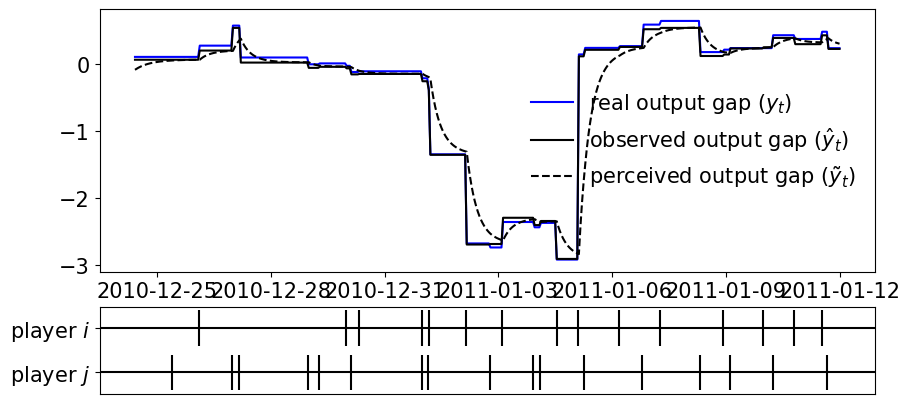

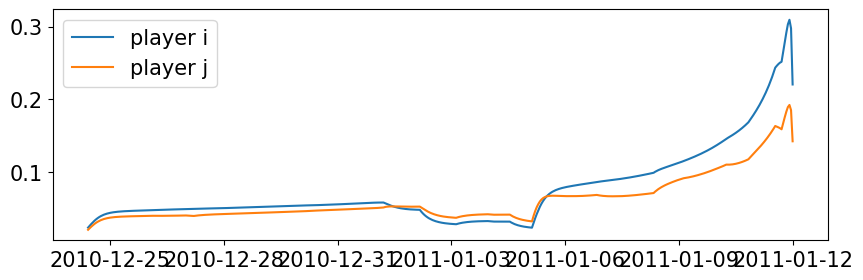

In [ ]:
_ = plot_contest_data(contest_data_json, contest_data_post)
plot_post_efforts(contest_data_json, contest_data_post)

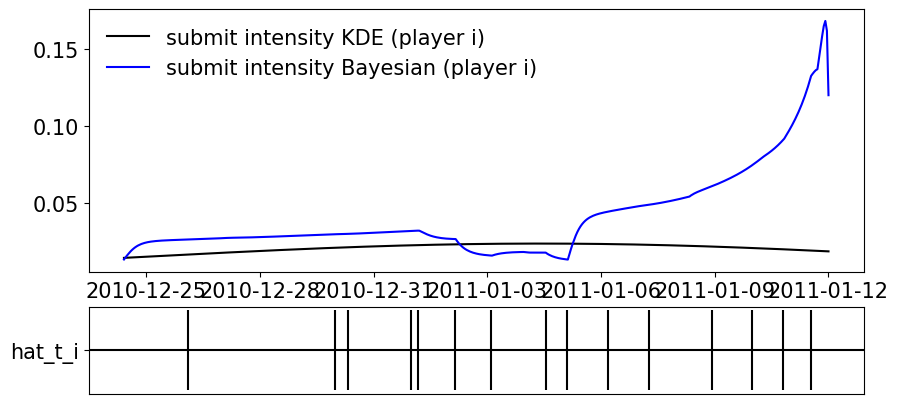

In [ ]:
# Display submission intensity
contest_m_i = contest_data_post['m_i'].mean(axis=0)
contest_m_j = contest_data_post['m_j'].mean(axis=0)
contest_r = contest_data_post['r'].mean()
time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j = estimate_effort_kde(contest_data_json, 2)
_ = plot_ts_events(time_grids, ts={
	'submit intensity KDE (player i)': intensity_i,
	'submit intensity Bayesian (player i)': contest_m_i * contest_r / 24,
	#'submit intensity (player j)': intensity_j,
	#'effort level (player j)': contest_m_j,
}, events={
	'hat_t_i': hat_t_i,
	#'hat_t_j': hat_t_j,
}, ts_colors = ['black', 'blue', 'black', 'blue'], ts_linestyles = ['solid', 'solid', 'dashed', 'dashed'],
)

#### Validate $\lambda$

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mle   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     7.563
Date:                Mon, 04 Aug 2025   Prob (F-statistic):            0.00755
Time:                        09:41:33   Log-Likelihood:                -182.79
No. Observations:                  73   AIC:                             369.6
Df Residuals:                      71   BIC:                             374.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2901      3.819     -0.076      0.940      -7.905       7.324
bayes          3.4210      1.244      2.750      0.008       0.941       5.901
==============================================================================
Omnibus:                        3.192   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.424
Skew:                          -0.411   Prob(JB):                        0.298
Kurtosis:                       3.350   Cond. No.                         36.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

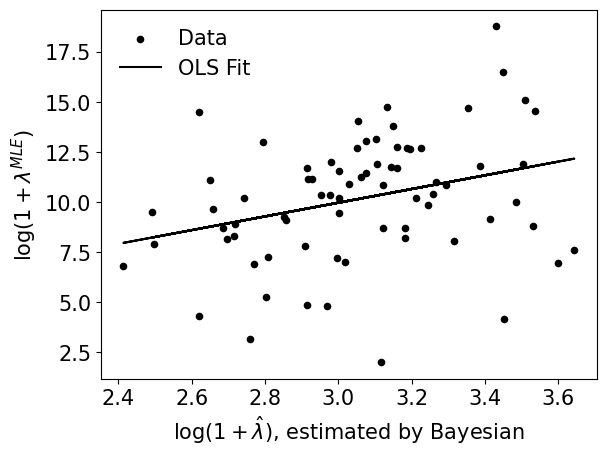

In [ ]:
lamb_hat_bayes = np.log(1 + cross_contests['lambda_post_mean'])
lamb_hat_mle = np.log(1 + cross_contests['lambda_mle'])

df_lamb = pd.DataFrame({
	'bayes': lamb_hat_bayes,
	'mle': lamb_hat_mle
}).dropna()

X_lamb = sm.add_constant(df_lamb['bayes'])
y_lamb = df_lamb['mle']

model_lambda = sm.OLS(y_lamb, X_lamb).fit()
lamb_hat_fit = model_lambda.predict(X_lamb)
display(model_lambda.summary())

plt.rcParams.update({'font.size': 15})
plt.scatter(df_lamb['bayes'], y_lamb, s=20, label="Data", color="black", )
plt.plot(df_lamb['bayes'], lamb_hat_fit, label="OLS Fit", color="black")
plt.xlabel(r"$\log(1+\hat\lambda)$, estimated by Bayesian")
plt.ylabel(r"$\log(1+\lambda^{MLE})$")
plt.legend(loc='upper left', frameon=False)
plt.show()

,student_resid,unadj_p,bonf(p)
1,-0.559222,0.577795,1.0
2,-1.009738,0.316098,1.0
3,-0.154592,0.877588,1.0
4,0.788249,0.433212,1.0
5,-1.499222,0.138313,1.0
...,...,...,...
70,0.702352,0.484789,1.0
71,-0.075158,0.940303,1.0
72,-1.372130,0.174404,1.0
73,0.860472,0.392467,1.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mle   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     7.563
Date:                Mon, 04 Aug 2025   Prob (F-statistic):            0.00755
Time:                        09:41:33   Log-Likelihood:                -182.79
No. Observations:                  73   AIC:                             369.6
Df Residuals:                      71   BIC:                             374.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2901      3.819     -0.076      0.940      -7.905       7.324
bayes          3.4210      1.244      2.750      0.008       0.941       5.901
==============================================================================
Omnibus:                        3.192   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.424
Skew:                          -0.411   Prob(JB):                        0.298
Kurtosis:                       3.350   Cond. No.                         36.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

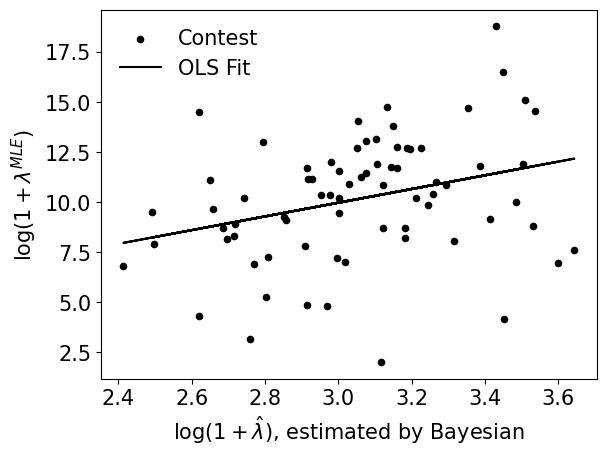

In [ ]:
outlier_test_result = model_lambda.outlier_test(method='bonf', alpha=0.05)
# outlier_test_result = outlier_test_result_unclean.dropna(subset=['bonf(p)'])

display(outlier_test_result)
non_outliers = outlier_test_result['bonf(p)'] > 0.05
outliers = outlier_test_result['bonf(p)'] <= 0.05
X_lamb_clean = X_lamb[non_outliers]
y_lamb_clean = y_lamb[non_outliers]
model_sigma_clean = sm.OLS(y_lamb_clean, X_lamb_clean, missing='drop').fit()
sigma_hat_fit_clean = model_sigma_clean.predict(X_lamb)
display(model_sigma_clean.summary())

plt.rcParams.update({'font.size': 15})
if sum(outliers) > 0:
	plt.scatter(df_lamb['bayes'][outliers], y_lamb[outliers],
			s=20, label="Outliers", color="red")
plt.scatter(df_lamb['bayes'][non_outliers], y_lamb[non_outliers],
		s=20, label="Contest", color="black")
plt.plot(df_lamb['bayes'], sigma_hat_fit_clean, label="OLS Fit", color="black")

plt.xlabel(r"$\log(1+\hat\lambda)$, estimated by Bayesian")
plt.ylabel(r"$\log(1+\lambda^{MLE})$")
plt.legend(loc='upper left', frameon=False)
plt.savefig("../paper/validate_lamb_robust23.pdf", bbox_inches='tight')
plt.show()

#### Validate $\sigma$

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sigma_mle   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     5.620
Date:                Mon, 04 Aug 2025   Prob (F-statistic):             0.0204
Time:                        09:41:33   Log-Likelihood:                -19.010
No. Observations:                  75   AIC:                             42.02
Df Residuals:                      73   BIC:                             46.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1166      0.130      0.900      0.371      -0.142       0.375
sigma_post_mean     0.5014      0.212      2.371      0.020       0.080       0.923
==============================================================================
Omnibus:                       12.724   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.657
Skew:                           1.015   Prob(JB):                      0.00108
Kurtosis:                       3.501   Cond. No.                         7.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

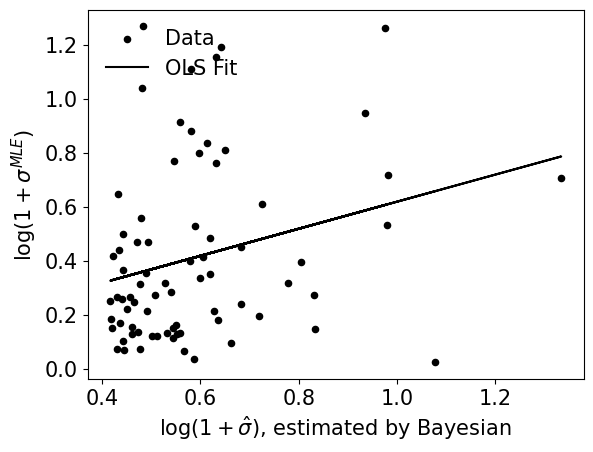

In [ ]:
sigma_hat_bayes = np.log(1 + cross_contests['sigma_post_mean'])
sigma_hat_mle = np.log(1 + cross_contests['sigma_mle'])
X_sigma = sm.add_constant(sigma_hat_bayes)
model_sigma = sm.OLS(sigma_hat_mle, X_sigma).fit()
sigma_hat_fit = model_sigma.predict(X_sigma)
display(model_sigma.summary())

plt.rcParams.update({'font.size': 15})
plt.scatter(sigma_hat_bayes, sigma_hat_mle, s=20, label="Data", color="black", )
plt.plot(sigma_hat_bayes, sigma_hat_fit, label="OLS Fit", color="black")
plt.xlabel(r"$\log(1+\hat\sigma)$, estimated by Bayesian")
plt.ylabel(r"$\log(1+\sigma^{MLE})$")
plt.legend(loc='upper left', frameon=False)
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sigma_mle   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     5.620
Date:                Mon, 04 Aug 2025   Prob (F-statistic):             0.0204
Time:                        09:41:33   Log-Likelihood:                -19.010
No. Observations:                  75   AIC:                             42.02
Df Residuals:                      73   BIC:                             46.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1166      0.130      0.900      0.371      -0.142       0.375
sigma_post_mean     0.5014      0.212      2.371      0.020       0.080       0.923
==============================================================================
Omnibus:                       12.724   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.657
Skew:                           1.015   Prob(JB):                      0.00108
Kurtosis:                       3.501   Cond. No.                         7.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

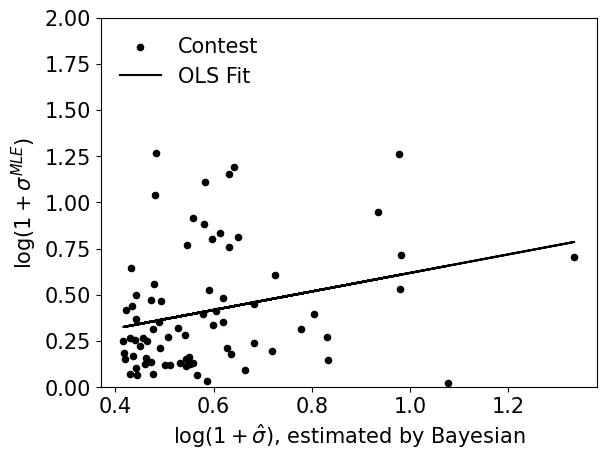

In [ ]:
outlier_test_result = model_sigma.outlier_test(method='bonf', alpha=0.05)
#display(outlier_test_result)
non_outliers = outlier_test_result['bonf(p)'] > 0.05
outliers = outlier_test_result['bonf(p)'] <= 0.05
X_sigma_clean = X_sigma[non_outliers]
y_sigma_clean = sigma_hat_mle[non_outliers]
model_sigma_clean = sm.OLS(y_sigma_clean, X_sigma_clean).fit()
sigma_hat_fit_clean = model_sigma_clean.predict(X_sigma)
display(model_sigma_clean.summary())

plt.rcParams.update({'font.size': 15})
if sum(outliers):
	plt.scatter(sigma_hat_bayes[outliers], sigma_hat_mle[outliers],
			s=20, label="Outliers", color="red", )
plt.scatter(sigma_hat_bayes[non_outliers], sigma_hat_mle[non_outliers],
		s=20, label="Contest", color="black", )
plt.plot(sigma_hat_bayes, sigma_hat_fit_clean, label="OLS Fit", color="black")
plt.ylim((0, 2))
plt.xlabel(r"$\log(1+\hat\sigma)$, estimated by Bayesian")
plt.ylabel(r"$\log(1+\sigma^{MLE})$")
plt.legend(loc='upper left', frameon=False)
plt.savefig("../paper/validate_sigma_robust23.pdf", bbox_inches='tight')
plt.show()